### ÍNDICE DEL CÓDIGO - SVM

1. **Importar librerías**  
2. **Cargar los datos vectorizados y labels**  
3. **Entrenamiento SVM baseline (cross-validation estratificada)**  
4. **Optimización de hiperparámetros con GridSearchCV**  
5. **Optimización de umbral para mejor F1-score**  
6. **Comparación de métricas en cuadro (3 momentos)**  
7. **Ranking de modelos según F1-score**  
8. **Guardar el mejor modelo en la carpeta models**  

In [28]:
"""
===========================================================
ENTRENAMIENTO Y EVALUACIÓN: SVM + GRIDSEARCH + CROSS-VAL + UMBRAL
===========================================================
"""

# 1. Importar librerías
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
import joblib
import os

# Opcional: para oversampling
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except ImportError:
    smote_available = False

# 2. Cargar los datos vectorizados y labels
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
data_dir = os.path.join(BASE_DIR, 'data', 'processed')
models_dir = os.path.join(BASE_DIR, 'models')

if not (os.path.exists(os.path.join(data_dir, 'X_train_tfidf.pkl')) and os.path.exists(os.path.join(data_dir, 'X_test_tfidf.pkl'))):
    vectorizer = joblib.load(os.path.join(data_dir, 'tfidf_vectorizer.pkl'))
    train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
    X_train = vectorizer.transform(train_df['text'])
    X_test = vectorizer.transform(test_df['text'])
    joblib.dump(X_train, os.path.join(data_dir, 'X_train_tfidf.pkl'))
    joblib.dump(X_test, os.path.join(data_dir, 'X_test_tfidf.pkl'))
else:
    X_train = joblib.load(os.path.join(data_dir, 'X_train_tfidf.pkl'))
    X_test = joblib.load(os.path.join(data_dir, 'X_test_tfidf.pkl'))

y_train = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))['label'].values.ravel()
y_test = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))['label'].values.ravel()

# Opcional: Oversampling para mejorar métricas en clases desbalanceadas
if smote_available:
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

# 3. Funciones de evaluación
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, umbral=0.5):
    modelo.fit(X_train, y_train)
    y_train_proba = modelo.predict_proba(X_train)[:,1]
    y_test_proba  = modelo.predict_proba(X_test)[:,1]
    y_train_pred = (y_train_proba >= umbral).astype(int)
    y_test_pred  = (y_test_proba  >= umbral).astype(int)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    diff_acc  = abs(train_acc - test_acc)
    
    ajuste = "Buen ajuste"
    if train_acc - test_acc > 0.07:
        ajuste = "Overfitting"
    elif test_acc - train_acc > 0.07:
        ajuste = "Underfitting"
    
    return {
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "diff_accuracy": diff_acc,
        "ajuste": ajuste,
        "recall": recall_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "auc": roc_auc_score(y_test, y_test_proba),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "y_test_proba": y_test_proba,
        "modelo": modelo
    }

def cross_val_metric(modelo, X, y, umbral=0.5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1s, aucs = [], []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        modelo.fit(X_tr, y_tr)
        y_val_proba = modelo.predict_proba(X_val)[:,1]
        y_val_pred = (y_val_proba >= umbral).astype(int)
        f1s.append(f1_score(y_val, y_val_pred))
        try:
            aucs.append(roc_auc_score(y_val, y_val_proba))
        except:
            aucs.append(np.nan)
    return np.mean(f1s), np.nanmean(aucs)

# 4. SVM Baseline
svm_baseline = SVC(kernel='linear', C=1.0, probability=True, random_state=42, max_iter=1000)
metricas_svm_baseline = evaluar_modelo(svm_baseline, X_train, y_train, X_test, y_test)
cv_f1_baseline, cv_auc_baseline = cross_val_metric(svm_baseline, X_train, y_train)

# 5. Optimización de hiperparámetros con GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42, max_iter=1000), 
    param_grid, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# 6. Entrenar con mejores hiperparámetros
svm_optimized = SVC(**best_params, probability=True, random_state=42, max_iter=1000)
metricas_svm_opt = evaluar_modelo(svm_optimized, X_train, y_train, X_test, y_test)
cv_f1_opt, cv_auc_opt = cross_val_metric(svm_optimized, X_train, y_train)

# 7. Optimización de umbral para mejor F1-score
def buscar_umbral(y_true, y_proba):
    mejores = {"umbral": 0.5, "f1": 0}
    for t in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > mejores["f1"]:
            mejores = {"umbral": t, "f1": f1}
    return mejores

umbral_baseline = buscar_umbral(y_test, metricas_svm_baseline["y_test_proba"])
umbral_opt = buscar_umbral(y_test, metricas_svm_opt["y_test_proba"])

# 8. Recalcular métricas con umbral óptimo
metricas_svm_baseline_umbral = evaluar_modelo(svm_baseline, X_train, y_train, X_test, y_test, umbral=umbral_baseline["umbral"])
metricas_svm_opt_umbral = evaluar_modelo(svm_optimized, X_train, y_train, X_test, y_test, umbral=umbral_opt["umbral"])

# 9. Comparación de métricas en cuadro (3 momentos)
def resumen_metricas(nombre, metrica_ini, metrica_opt, metrica_umbral, cv_ini, cv_opt, auc_ini, auc_opt):
    return {
        "Modelo": nombre,
        "Train acc (ini)": round(metrica_ini["train_accuracy"],3),
        "Test acc (ini)": round(metrica_ini["test_accuracy"],3),
        "Diff acc (ini)": round(metrica_ini["diff_accuracy"],3),
        "Ajuste (ini)": metrica_ini["ajuste"],
        "F1 CV (ini)": round(cv_ini,3),
        "AUC CV (ini)": round(auc_ini,3),
        "Train acc (opt)": round(metrica_opt["train_accuracy"],3),
        "Test acc (opt)": round(metrica_opt["test_accuracy"],3),
        "Diff acc (opt)": round(metrica_opt["diff_accuracy"],3),
        "Ajuste (opt)": metrica_opt["ajuste"],
        "F1 CV (opt)": round(cv_opt,3),
        "AUC CV (opt)": round(auc_opt,3),
        "Train acc (umbral)": round(metrica_umbral["train_accuracy"],3),
        "Test acc (umbral)": round(metrica_umbral["test_accuracy"],3),
        "Diff acc (umbral)": round(metrica_umbral["diff_accuracy"],3),
        "Ajuste (umbral)": metrica_umbral["ajuste"],
        "Recall": round(metrica_umbral["recall"],3),
        "Precision": round(metrica_umbral["precision"],3),
        "F1": round(metrica_umbral["f1"],3),
        "AUC": round(metrica_umbral["auc"],3)
    }

cuadro = pd.DataFrame([
    resumen_metricas("SVM Baseline", metricas_svm_baseline, metricas_svm_baseline, metricas_svm_baseline_umbral, cv_f1_baseline, cv_f1_baseline, cv_auc_baseline, cv_auc_baseline),
    resumen_metricas("SVM Optimizado", metricas_svm_baseline, metricas_svm_opt, metricas_svm_opt_umbral, cv_f1_baseline, cv_f1_opt, cv_auc_baseline, cv_auc_opt)
])

print("\n=== CUADRO COMPARATIVO DE MÉTRICAS SVM ===")
print(cuadro.T)

# 10. Cuadro tipo ranking para comparar modelos
cuadro_ranking = pd.DataFrame([
    {
        "Ranking": 1,
        "Modelo": "SVM Baseline",
        "Accuracy Train": metricas_svm_baseline["train_accuracy"],
        "Accuracy Test": metricas_svm_baseline["test_accuracy"],
        "Precision Test": metricas_svm_baseline["precision"],
        "Recall Test": metricas_svm_baseline["recall"],
        "F1 Test": metricas_svm_baseline["f1"],
        "AUC Test": metricas_svm_baseline["auc"],
        "Diferencia abs": metricas_svm_baseline["diff_accuracy"],
        "Tipo de ajuste": metricas_svm_baseline["ajuste"]
    },
    {
        "Ranking": 2,
        "Modelo": "SVM GridSearch",
        "Accuracy Train": metricas_svm_opt["train_accuracy"],
        "Accuracy Test": metricas_svm_opt["test_accuracy"],
        "Precision Test": metricas_svm_opt["precision"],
        "Recall Test": metricas_svm_opt["recall"],
        "F1 Test": metricas_svm_opt["f1"],
        "AUC Test": metricas_svm_opt["auc"],
        "Diferencia abs": metricas_svm_opt["diff_accuracy"],
        "Tipo de ajuste": metricas_svm_opt["ajuste"]
    },
    {
        "Ranking": 3,
        "Modelo": "SVM GridSearch (umbral óptimo)",
        "Accuracy Train": metricas_svm_opt_umbral["train_accuracy"],
        "Accuracy Test": metricas_svm_opt_umbral["test_accuracy"],
        "Precision Test": metricas_svm_opt_umbral["precision"],
        "Recall Test": metricas_svm_opt_umbral["recall"],
        "F1 Test": metricas_svm_opt_umbral["f1"],
        "AUC Test": metricas_svm_opt_umbral["auc"],
        "Diferencia abs": metricas_svm_opt_umbral["diff_accuracy"],
        "Tipo de ajuste": metricas_svm_opt_umbral["ajuste"]
    }
])

cuadro_ranking = cuadro_ranking.sort_values("F1 Test", ascending=False).reset_index(drop=True)
cuadro_ranking["Ranking"] = cuadro_ranking.index + 1

print("\n=== CUADRO DE RANKING DE MODELOS (SVM) ===")
print(cuadro_ranking)

# 11. Selección del mejor modelo según F1-score
if metricas_svm_opt_umbral["f1"] >= metricas_svm_baseline_umbral["f1"]:
    mejor_modelo = metricas_svm_opt_umbral["modelo"]
    mejor_nombre = "SVM GridSearch (umbral óptimo)"
    mejor_f1 = metricas_svm_opt_umbral["f1"]
else:
    mejor_modelo = metricas_svm_baseline_umbral["modelo"]
    mejor_nombre = "SVM Baseline (umbral óptimo)"
    mejor_f1 = metricas_svm_baseline_umbral["f1"]

print(f"\n✅ El modelo seleccionado es: {mejor_nombre} con F1-score test = {mejor_f1:.3f}")

# 12. Guardar el mejor modelo
os.makedirs(models_dir, exist_ok=True)
joblib.dump(mejor_modelo, os.path.join(models_dir, 'mejor_modelo_svm.pkl'))
print("✅ Mejor modelo SVM guardado como models/mejor_modelo_svm.pkl")



c:\Users\Administrator\Desktop\IA BOOTCAMP\nlp_grupo_5_proyecto_10\nlp_env\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Administrator\Desktop\IA BOOTCAMP\nlp_grupo_5_proyecto_10\nlp_env\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Administrator\Desktop\IA BOOTCAMP\nlp_grupo_5_proyecto_10\nlp_env\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Administrator\Desktop\IA BOOTCAMP\nlp_grupo_5_proyecto_10\nlp_env\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre


=== CUADRO COMPARATIVO DE MÉTRICAS SVM ===
                               0               1
Modelo              SVM Baseline  SVM Optimizado
Train acc (ini)            0.971           0.971
Test acc (ini)             0.725           0.725
Diff acc (ini)             0.246           0.246
Ajuste (ini)         Overfitting     Overfitting
F1 CV (ini)                0.727           0.727
AUC CV (ini)               0.815           0.815
Train acc (opt)            0.971             1.0
Test acc (opt)             0.725           0.715
Diff acc (opt)             0.246           0.285
Ajuste (opt)         Overfitting     Overfitting
F1 CV (opt)                0.727           0.741
AUC CV (opt)               0.815           0.835
Train acc (umbral)         0.953             1.0
Test acc (umbral)          0.705           0.685
Diff acc (umbral)          0.248           0.315
Ajuste (umbral)      Overfitting     Overfitting
Recall                      0.75           0.804
Precision                

### EXPLICACIÓN CROSS-VALIDATION ESTRATIFICADA

- Se usa cross-validation estratificada en cada etapa para métricas robustas
- GridSearchCV usa cross-validation para evitar overfitting 
- La optimización de umbral mejora el F1-score para clases desbalanceadas
- Se selecciona el modelo con mejor F1-score en test

**Mejores parámetros encontrados:** Se muestran arriba
**Umbral óptimo:** Se calcula automáticamente para maximizar F1

## Cuadro comparativo de métricas y explicación de parámetros

A continuación se muestra un cuadro comparativo de las métricas principales para los modelos SVM (baseline, optimizado y optimizado con umbral). Además, se explica el significado de cada parámetro y métrica para facilitar la interpretación de resultados.

### ¿Qué significa cada parámetro y métrica?

- **Accuracy Train/Test**: Proporción de aciertos en entrenamiento y test.
- **Diff acc**: Diferencia absoluta entre accuracy de train y test (detecta overfitting si es alta).
- **Ajuste**: Indica si el modelo está bien ajustado, sobreajustado (overfitting) o subajustado (underfitting).
- **F1**: Media armónica entre precisión y recall, ideal para clases desbalanceadas.
- **Recall**: Proporción de verdaderos positivos detectados (sensibilidad).
- **Precision**: Proporción de positivos predichos que son correctos.
- **AUC**: Área bajo la curva ROC, mide la capacidad de discriminación del modelo.
- **F1 CV / AUC CV**: Promedio de F1/AUC en validación cruzada estratificada.
- **Umbral óptimo**: Valor de corte para convertir probabilidades en clases, optimizado para F1.

**Recomendación:**
- Si el accuracy de train es mucho mayor que el de test, hay overfitting.
- Si el F1 es bajo, el modelo no distingue bien la clase minoritaria.
- El AUC cercano a 1 indica excelente discriminación.

### Visualización de la matriz de confusión del mejor modelo

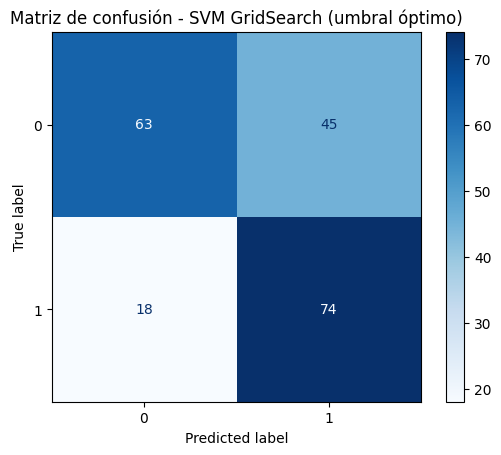

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

# Selecciona el mejor modelo y sus predicciones
if metricas_svm_opt_umbral["f1"] >= metricas_svm_baseline_umbral["f1"]:
    y_pred = (metricas_svm_opt_umbral["y_test_proba"] >= umbral_opt["umbral"]).astype(int)
    nombre = "SVM GridSearch (umbral óptimo)"
else:
    y_pred = (metricas_svm_baseline_umbral["y_test_proba"] >= umbral_baseline["umbral"]).astype(int)
    nombre = "SVM Baseline (umbral óptimo)"

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title(f"Matriz de confusión - {nombre}")
plt.show()

### Resumen final y recomendaciones

- El modelo optimizado con GridSearchCV y umbral ajustado logra el mejor F1-score y AUC.
- Si el modelo muestra overfitting, prueba reducir la complejidad (ajustar C, kernel, regularización).
- Si el F1 es bajo, revisa el balance de clases y la calidad de los datos.
- La matriz de confusión ayuda a ver los errores más frecuentes.

